In [1]:
#import all the packages you need
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#generate list for mock
PATH = os.getcwd()
print(PATH)
os.listdir(PATH)

G:\117\117_20190707_H3K9me3quant_repKrepL\_pipeline\v2


['.ipynb_checkpoints',
 '117_201900707_repEGI_GRAPH_gB_Hoechst_WITHticks.png',
 '117_201900707_repEGI_GRAPH_gB_NOticks.png',
 '117_201900707_repEGI_GRAPH_gB_WITHticks.png',
 '117_201900707_repEGI_GRAPH_H3K9me3_NOticks.png',
 '117_201900707_repEGI_GRAPH_H3K9me3_WITHticks.png',
 '117_201900707_repEGI_GRAPH_Hoechst_NOticks.png',
 '117_201900707_repEGI_GRAPH_Hoechst_WITHticks.png',
 '117_20190707_H3K9me3quant_repL_v2CNNexport_usingMODEL_117_20190601_H3K9me3quant_repE_v1.csv',
 '117_20190707_H3K9me3quant_repL_v2CNNexport_usingMODEL_117_20190707_H3K9me3quant_repL_v.csv',
 '117_20190707_H3K9me3quant_repL_v2Cytoplasm.csv',
 '117_20190707_H3K9me3quant_repL_v2Experiment.csv',
 '117_20190707_H3K9me3quant_repL_v2Image.csv',
 '117_20190707_H3K9me3quant_repL_v2NUC_DAPI.csv',
 '117_20190707_H3K9me3quant_repL_v2NUC_expanded.csv',
 '117_20190707_H3K9me3quant_repL_v2_IDsandCoords.csv',
 'CNNpredictions_20190710_0714',
 'CNNpredictions_20190710_1241',
 'CNNpredictions_20190710_1321',
 'fastai',
 'H3K9me3

### Create list of files in TB_perfect folders from our training, validation and v4 high confidnece (99%) CNN sorted dataset

In [3]:
exp_var = "117_20190707_H3K9me3quant_repL_v2"
date_var = 20190710
time_var = "1321"
#### make this a drop down box ####
MOCK_confidece_list = [99]
TB_confidence_list = [99]

MOCK_files = []
for conf in MOCK_confidece_list:
    MOCK_files_single_folder = os.listdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\{conf}confidence\\MOCK')
    print(f'Loading {len(MOCK_files_single_folder)} files for MOCK {conf}confidence')
    MOCK_files = MOCK_files + MOCK_files_single_folder
print(f'Loaded {len(MOCK_files)} files total for TB')

TB_files = []
for conf in TB_confidence_list:
    TB_files_single_folder = os.listdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\{conf}confidence\\TB_perfect')
    print(f'Loading {len(TB_files_single_folder)} files for TB {conf}confidence')
    TB_files = TB_files + TB_files_single_folder
print(f'Loaded {len(TB_files)} files total for TB')

#convert these lists to a dataframe
df_TB_ID = pd.DataFrame({'Unique_ID':TB_files})
df_MOCK_ID = pd.DataFrame({'Unique_ID':MOCK_files})

#strip "_RGB.jpg" from filename to match UNIQUE ID
df_TB_ID['Unique_ID'].replace(regex=True,inplace=True,to_replace='_RGB.jpg',value='')
df_MOCK_ID['Unique_ID'].replace(regex=True,inplace=True,to_replace='_RGB.jpg',value='')

#filter mock for only in mock sample (there are obviously some uninfected cells in the TB infected samples)
df_MOCK_ID = df_MOCK_ID[df_MOCK_ID['Unique_ID'].str.contains('MOCK')]
print(df_MOCK_ID.shape)
#filter TB for only in TB sample (just in case)
df_TB_ID = df_TB_ID[df_TB_ID['Unique_ID'].str.contains('_96hpi_')]
print(df_TB_ID.shape)

# IMPORT DATAFRAME WHERE WE CREATED THE IDs and COORDS FOR THIS DATASET
df_coords = pd.read_csv(f'{exp_var}_IDsandCoords.csv')
#df_FULL = pd.read_csv("117_20181023_SUN2_v4_IDsandCoords_FULL.csv") #create a FULL version of the dataframe in the Generate IDs and coords notebook

# Merge coords with lists from CNN sorting for TB
df_TB_CNNsorted99_coords = df_coords.merge(df_TB_ID, left_on='Unique_ID', right_on='Unique_ID', how='right')
df_MOCK_CNNsorted99_coords = df_coords.merge(df_MOCK_ID, left_on='Unique_ID', right_on='Unique_ID', how='right')
#df_TB_CNNsorted99_FULL = df_FULL.merge(df_TB_ID, left_on='Unique_ID', right_on='Unique_ID', how='right')
#df_MOCK_CNNsorted99_FULL = df_FULL.merge(df_MOCK_ID, left_on='Unique_ID', right_on='Unique_ID', how='right')

Loading 2960 files for MOCK 99confidence
Loaded 2960 files total for TB
Loading 1393 files for TB 99confidence
Loaded 1393 files total for TB
(1843, 1)
(1390, 1)


In [4]:
#now we need to generate the x1,y1 and x2,y2 coords for the MOCK nuclei
#set the length of the linescan to be performed
linescan_len = 1000 # lenght in pixels
radius_len = linescan_len/2

df_merge_OUTPUT = df_MOCK_CNNsorted99_coords

#get the orientation of the minor axis in radians
df_merge_OUTPUT['NUC_orientation_radians'] = (df_merge_OUTPUT[('AreaShape_Orientation')]+90).apply(np.radians)

#calculate the coordinates of points (x1,y1), (x2,y2) drawing a 300 pixel line along the minor axis and passing through the center of the nucleus 
df_merge_OUTPUT['NUC_x1'] = df_merge_OUTPUT['NUC_x0'] + df_merge_OUTPUT['NUC_orientation_radians'].apply(np.cos).multiply(radius_len)
df_merge_OUTPUT['NUC_y1'] = df_merge_OUTPUT['NUC_y0'] + df_merge_OUTPUT['NUC_orientation_radians'].apply(np.sin).multiply(radius_len)
df_merge_OUTPUT['NUC_x2'] = df_merge_OUTPUT['NUC_x0'] - df_merge_OUTPUT['NUC_orientation_radians'].apply(np.cos).multiply(radius_len)
df_merge_OUTPUT['NUC_y2'] = df_merge_OUTPUT['NUC_y0'] - df_merge_OUTPUT['NUC_orientation_radians'].apply(np.sin).multiply(radius_len)

df_MOCK_CNNsorted99_coords = df_merge_OUTPUT

In [5]:
df_MOCK_CNNsorted99_coords.head()

,Unique_ID,NUC_x0,NUC_y0,URL_C1,URL_C2,URL_C3,AreaShape_Orientation,CYTO_x0,CYTO_y0,NUC_orientation_radians,NUC_x1,NUC_y1,NUC_x2,NUC_y2
0,117_20190707_repL_MOCK_1889_1,634.240409,217.299233,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,-76.308761,656.333584,246.939864,0.238957,1120.033071,335.644027,148.447748,98.954439
1,117_20190707_repL_MOCK_1889_5,1892.610659,1425.560976,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,74.942012,1840.299579,1414.353219,2.878781,1409.778967,1555.459229,2375.442352,1295.662722
2,117_20190707_repL_MOCK_1889_6,409.711020,1480.875102,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,-74.380963,406.683871,1474.304442,0.272604,891.247603,1615.495010,-71.825562,1346.255194
3,117_20190707_repL_MOCK_1890_5,339.251232,1169.064039,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,69.205748,338.049048,1161.381723,2.778664,-128.179418,1346.570624,806.681881,991.557455
4,117_20190707_repL_MOCK_1890_6,782.685714,1699.723810,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,87.724510,795.277497,1692.363289,3.101878,283.079979,1719.575986,1282.291450,1679.871633


In [6]:
#Now because imageJ needs these broken up into individual smaller CSV files to run efficiently
split_number =25
base_filename_for_csvs = f'{exp_var}_MOCK_99conf_sorted_IDandCOORDS_overfolder'
os.mkdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_csvfolderMOCK')
os.mkdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_profileMOCK')
for g, df in df_MOCK_CNNsorted99_coords.groupby(np.arange(len(df_MOCK_CNNsorted99_coords)) // split_number):
    #print(df.shape)  #can get rid of this line
    df.name = g #can get rid of this line
    #print(df.name) #can get rid of this line
    name = f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_csvfolderMOCK\\{base_filename_for_csvs}_{str(g)}.csv'
    df.to_csv(name, index=False)   

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'G:\\117\\117_20190707_H3K9me3quant_repKrepL\\_pipeline\\v2\\CNNpredictions_20190710_1321\\_csvfolderMOCK'

In [11]:
import pandas as pd
import glob

path = f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_profileMOCK' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, na_values=0, index_col=None, header=0)
    df.drop(df.columns[0], axis=1, inplace=True)
    li.append(df)

concat_df_MOCK = pd.concat(li, axis=1)

In [12]:
print(concat_df_MOCK.shape)
concat_df_MOCK.head()

(1001, 3375)


,117_20190707_repL_MOCK_1889_1_C1,117_20190707_repL_MOCK_1889_1_C2,117_20190707_repL_MOCK_1889_1_C3,117_20190707_repL_MOCK_1889_5_C1,117_20190707_repL_MOCK_1889_5_C2,117_20190707_repL_MOCK_1889_5_C3,117_20190707_repL_MOCK_1889_6_C1,117_20190707_repL_MOCK_1889_6_C2,117_20190707_repL_MOCK_1889_6_C3,117_20190707_repL_MOCK_1890_5_C1,...,117_20190707_repL_MOCK_2622_3_C3,117_20190707_repL_MOCK_2622_6_C1,117_20190707_repL_MOCK_2622_6_C2,117_20190707_repL_MOCK_2622_6_C3,117_20190707_repL_MOCK_2622_8_C1,117_20190707_repL_MOCK_2622_8_C2,117_20190707_repL_MOCK_2622_8_C3,117_20190707_repL_MOCK_2622_9_C1,117_20190707_repL_MOCK_2622_9_C2,117_20190707_repL_MOCK_2622_9_C3
0,1246.768264,1202.902462,305.561094,1480.933019,1309.453526,390.913363,1085.159269,1467.032796,348.855427,NaN,...,746.406744,NaN,NaN,NaN,1073.389307,1658.465350,442.633366,NaN,NaN,NaN
1,1232.176807,1211.256396,307.044313,1507.352534,1308.705867,390.048725,1081.009787,1468.988632,349.665350,NaN,...,760.189439,NaN,NaN,NaN,1078.404984,1658.859299,442.787892,NaN,NaN,NaN
2,1230.237850,1215.190102,309.736425,1515.503261,1311.221720,392.681544,1090.681465,1468.515846,351.177416,NaN,...,775.390061,NaN,NaN,NaN,1079.868761,1659.535514,444.150020,NaN,NaN,NaN
3,1225.911435,1215.370883,304.915843,1523.489273,1312.244390,393.603611,1092.661043,1469.575737,352.733515,NaN,...,788.266286,NaN,NaN,NaN,1075.813121,1647.187453,442.114433,NaN,NaN,NaN
4,1221.844333,1216.993581,301.607870,1528.681963,1319.044594,392.514963,1090.725481,1475.318175,349.394345,NaN,...,799.689370,NaN,NaN,NaN,1085.086327,1641.773575,443.833094,NaN,NaN,NaN


In [13]:
rep_val = "repL"
concat_df_MOCK.filter(like=rep_val, axis=1).to_csv(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\{exp_var}_MOCK_LINESCANS_{rep_val}_only.csv', index=False)  
print(concat_df_MOCK.filter(like=rep_val, axis=1).shape) 

(1001, 3375)


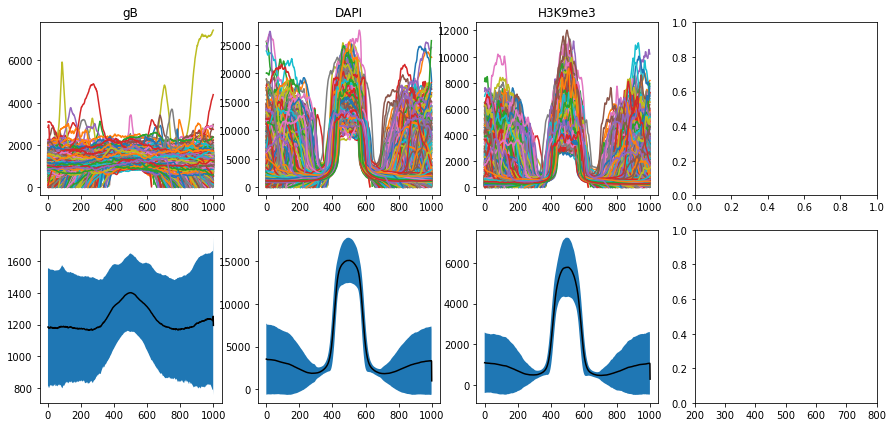

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

df_linescan_MOCK_500 = concat_df_MOCK

df_linescan_MOCK_500_C1 = df_linescan_MOCK_500.filter(regex='C1')
df_linescan_MOCK_500_C2 = df_linescan_MOCK_500.filter(regex='C2')
df_linescan_MOCK_500_C3 = df_linescan_MOCK_500.filter(regex='C3')


titles = ['gB', 'DAPI', 'H3K9me3']

figure, ax = plt.subplots(ncols=4, nrows=2, figsize=(15,7)) #sharex=True, sharey=True)

ax[0,0].set(title=titles[0])
ax[0,0].plot(df_linescan_MOCK_500_C1) 
ax[1,0].plot(df_linescan_MOCK_500_C1.mean(axis=1),'k-')

MOCK_C1_error_high = df_linescan_MOCK_500_C1.mean(axis=1) + df_linescan_MOCK_500_C1.std(axis=1)
MOCK_C1_error_low = df_linescan_MOCK_500_C1.mean(axis=1) - df_linescan_MOCK_500_C1.std(axis=1)
N=list(df_linescan_MOCK_500_C1.index)
ax[1,0].fill_between(N,MOCK_C1_error_high,MOCK_C1_error_low)

ax[0,1].set(title=titles[1])
ax[0,1].plot(df_linescan_MOCK_500_C2) 
ax[1,1].plot(df_linescan_MOCK_500_C2.mean(axis=1),'k-')
MOCK_C2_error_high = df_linescan_MOCK_500_C2.mean(axis=1) + df_linescan_MOCK_500_C2.std(axis=1)
MOCK_C2_error_low = df_linescan_MOCK_500_C2.mean(axis=1) - df_linescan_MOCK_500_C2.std(axis=1)
N=list(df_linescan_MOCK_500_C2.index)
ax[1,1].fill_between(N,MOCK_C2_error_high,MOCK_C2_error_low)


ax[0,2].set(title=titles[2])
ax[0,2].plot(df_linescan_MOCK_500_C3) 
ax[1,2].plot(df_linescan_MOCK_500_C3.mean(axis=1),'k-')
MOCK_C3_error_high = df_linescan_MOCK_500_C3.mean(axis=1) + df_linescan_MOCK_500_C3.std(axis=1)
MOCK_C3_error_low = df_linescan_MOCK_500_C3.mean(axis=1) - df_linescan_MOCK_500_C3.std(axis=1)
N=list(df_linescan_MOCK_500_C3.index)
ax[1,2].fill_between(N,MOCK_C3_error_high,MOCK_C3_error_low)
ax[1,3].set_xlim(200,800)
plt.show()

### NOW PERFORM ON TB

In [8]:
df_merge_OUTPUT = df_TB_CNNsorted99_coords

In [9]:
#get the center of the AC (AC_x0)(we will filter out for uninfected cells later)
df_merge_OUTPUT['AC_x0'] = df_merge_OUTPUT['CYTO_x0']
df_merge_OUTPUT['AC_y0'] = df_merge_OUTPUT['CYTO_y0']

#calculate the AC to NUC orientation in radians 
df_TB_CNNsorted99_coords["AC_to_NUC_orientation_radians"] =  np.arctan2((df_merge_OUTPUT['AC_y0'] - df_merge_OUTPUT['NUC_y0']),(df_merge_OUTPUT['AC_x0'] - df_merge_OUTPUT['NUC_x0']))

In [10]:
df_merge_OUTPUT.loc[df_merge_OUTPUT["AC_to_NUC_orientation_radians"]<0, ["AC_to_NUC_orientation_radians"]] = 2*np.pi+ df_merge_OUTPUT["AC_to_NUC_orientation_radians"]

In [11]:
#df_merge_OUTPUT["AC_to_NUC_orientation_radians"]

In [12]:
#NOTE THIS MAY SCREW UP FOR THE NEW WAY WE ARE SEGMENTING THE AC. YOU MAY HAVE TO RERUN FOR THE THINGS YOU KNOW YOU WANT TO PROCESS WITH LINESCANS
df_merge_OUTPUT["ACtoNUC_X_Midpoint"] = (df_merge_OUTPUT['NUC_x0'] + df_merge_OUTPUT['AC_x0'])/2
df_merge_OUTPUT["ACtoNUC_Y_Midpoint"] = (df_merge_OUTPUT['NUC_y0'] + df_merge_OUTPUT['AC_y0'])/2

radius_val = 1000

df_merge_OUTPUT["X_AC_fixedradius"] = df_merge_OUTPUT["ACtoNUC_X_Midpoint"] + radius_val *  np.cos(df_merge_OUTPUT['AC_to_NUC_orientation_radians'] - np.pi)
df_merge_OUTPUT["Y_AC_fixedradius"] = df_merge_OUTPUT["ACtoNUC_Y_Midpoint"] + radius_val *  np.sin(df_merge_OUTPUT['AC_to_NUC_orientation_radians'] - np.pi)

df_merge_OUTPUT["X_NUC_fixedradius"] = df_merge_OUTPUT["ACtoNUC_X_Midpoint"] + radius_val * np.cos(df_merge_OUTPUT['AC_to_NUC_orientation_radians'])
df_merge_OUTPUT["Y_NUC_fixedradius"] = df_merge_OUTPUT["ACtoNUC_Y_Midpoint"] + radius_val * np.sin(df_merge_OUTPUT['AC_to_NUC_orientation_radians'])
df_merge_OUTPUT["AC_to_NUC_orientation_degrees"] = df_merge_OUTPUT['AC_to_NUC_orientation_radians'].apply(np.degrees)

In [13]:
df_merge_OUTPUT.head()

,Unique_ID,NUC_x0,NUC_y0,URL_C1,URL_C2,URL_C3,AreaShape_Orientation,CYTO_x0,CYTO_y0,AC_x0,AC_y0,AC_to_NUC_orientation_radians,ACtoNUC_X_Midpoint,ACtoNUC_Y_Midpoint,X_AC_fixedradius,Y_AC_fixedradius,X_NUC_fixedradius,Y_NUC_fixedradius,AC_to_NUC_orientation_degrees
0,117_20190707_repL_96hpi_1_7,456.221607,1083.848569,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,84.582728,476.262823,1105.283803,476.262823,1105.283803,0.818995,466.242215,1094.566186,-216.713159,364.106086,1149.197589,1825.026286,46.924980
1,117_20190707_repL_96hpi_1_10,1628.101633,1833.698730,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,-46.706885,1607.201060,1797.393208,1607.201060,1797.393208,4.190039,1617.651347,1815.545969,2116.569074,2682.195322,1118.733620,948.896615,240.071577
2,117_20190707_repL_96hpi_5_4,389.585040,1578.614426,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,-63.515007,360.225458,1566.313431,360.225458,1566.313431,3.538351,374.905249,1572.463928,1297.223814,1958.894341,-547.413316,1186.033515,202.732571
3,117_20190707_repL_96hpi_7_1,216.729954,179.229493,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,38.340600,270.473726,185.928986,270.473726,185.928986,0.124016,243.601840,182.579240,-748.717972,58.880448,1235.921652,306.278031,7.105619
4,117_20190707_repL_96hpi_7_2,712.648824,390.124899,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,file:///G:/117/117_20190707_H3K9me3quant_repKr...,-38.086411,682.311529,392.099270,682.311529,392.099270,3.076604,697.480176,391.112085,1695.369132,326.168791,-300.408780,456.055378,176.276403


In [14]:
df_TB_CNNsorted99_coords_NUCtoAC = df_merge_OUTPUT
df_TB_CNNsorted99_coords_NUCtoAC.shape

(1390, 19)

In [15]:
### now do this over folders

In [16]:
#Now because imageJ needs these broken up into individual smaller CSV files to run efficiently
split_number =25
base_filename_for_csvs = f'{exp_var}_TB_99conf_sorted_IDandCOORDS_overfolder'
os.mkdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_csvfolderTB')
os.mkdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_profilesTB')
for g, df in df_TB_CNNsorted99_coords_NUCtoAC.groupby(np.arange(len(df_TB_CNNsorted99_coords_NUCtoAC)) // split_number):
    #print(df.shape)  #can get rid of this line
    df.name = g #can get rid of this line
    #print(df.name) #can get rid of this line
    name = f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_csvfolderTB\\{base_filename_for_csvs}_{str(g)}.csv'
    df.to_csv(name, index=False)   

In [17]:
import pandas as pd
import glob

path = f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_profilesTB' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, na_values=0, index_col=None, header=0)
    df.drop(df.columns[0], axis=1, inplace=True)
    li.append(df)

concat_df_TB = pd.concat(li, axis=1)

In [18]:
concat_df_TB.shape

(2000, 2250)

In [19]:
concat_df_TB.head()

,117_20190707_repL_96hpi_1_7_C1,117_20190707_repL_96hpi_1_7_C2,117_20190707_repL_96hpi_1_7_C3,117_20190707_repL_96hpi_1_10_C1,117_20190707_repL_96hpi_1_10_C2,117_20190707_repL_96hpi_1_10_C3,117_20190707_repL_96hpi_5_4_C1,117_20190707_repL_96hpi_5_4_C2,117_20190707_repL_96hpi_5_4_C3,117_20190707_repL_96hpi_7_1_C1,...,117_20190707_repL_96hpi_1183_4_C3,117_20190707_repL_96hpi_1183_5_C1,117_20190707_repL_96hpi_1183_5_C2,117_20190707_repL_96hpi_1183_5_C3,117_20190707_repL_96hpi_1184_4_C1,117_20190707_repL_96hpi_1184_4_C2,117_20190707_repL_96hpi_1184_4_C3,117_20190707_repL_96hpi_1186_3_C1,117_20190707_repL_96hpi_1186_3_C2,117_20190707_repL_96hpi_1186_3_C3
0,NaN,NaN,NaN,NaN,NaN,NaN,826.203386,5552.997835,2043.321324,NaN,...,3283.223376,NaN,NaN,NaN,NaN,NaN,NaN,999.596057,2219.799242,762.788887
1,NaN,NaN,NaN,NaN,NaN,NaN,833.361835,5625.207738,2052.033381,NaN,...,3382.776469,NaN,NaN,NaN,NaN,NaN,NaN,1006.557186,2217.906153,774.488560
2,NaN,NaN,NaN,NaN,NaN,NaN,842.483490,5669.041347,2076.028415,NaN,...,3503.652930,NaN,NaN,NaN,NaN,NaN,NaN,1008.637976,2218.758949,787.064786
3,NaN,NaN,NaN,NaN,NaN,NaN,844.418596,5672.938818,2104.470992,NaN,...,3632.445518,NaN,NaN,NaN,NaN,NaN,NaN,1017.473930,2223.633901,786.870568
4,NaN,NaN,NaN,NaN,NaN,NaN,848.546040,5706.418464,2143.935262,NaN,...,3738.575361,NaN,NaN,NaN,NaN,NaN,NaN,1022.559006,2237.195826,784.907934


In [20]:
biorep_li = ["repL"]

for biorep_val in biorep_li:
    print(f'{biorep_val} contrains {concat_df_TB.filter(like=biorep_val, axis=1).shape[1]/3:.0f} nuclei') 
    concat_df_TB.filter(like=biorep_val, axis=1).to_csv(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\{exp_var}_RawLinescans_TB_{biorep_val}_only.csv', index=False)   

repL contrains 750 nuclei


In [21]:
#these are the results for the random Mock 500 sample
df_linescan_TB= concat_df_TB

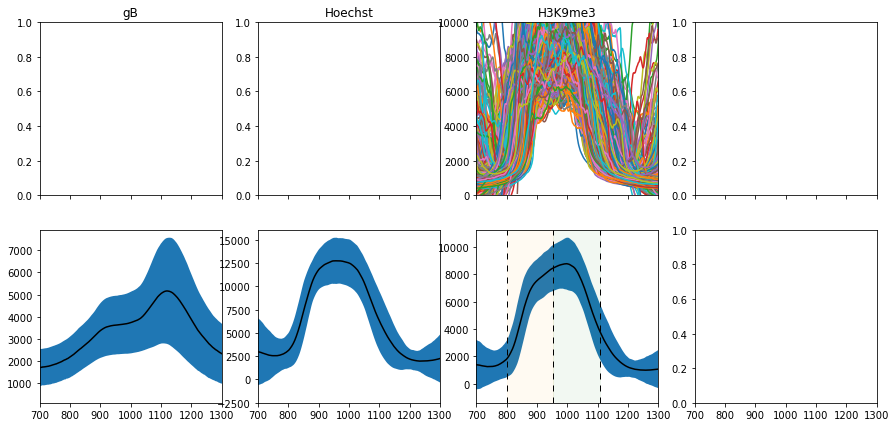

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

df_linescan_TB_C1 = df_linescan_TB.filter(regex='C1')
df_linescan_TB_C2 = df_linescan_TB.filter(regex='C2')
df_linescan_TB_C3 = df_linescan_TB.filter(regex='C3')

figure, ax = plt.subplots(ncols=4, nrows=2, figsize=(15,7), sharex=True) #, sharey=True)

ax[0,0].set(title="gB")
#ax[0,0].plot(df_linescan_TB_C1) 
ax[1,0].plot(df_linescan_TB_C1.mean(axis=1),'k-')

TB_C1_error_high = df_linescan_TB_C1.mean(axis=1) + df_linescan_TB_C1.std(axis=1)
TB_C1_error_low = df_linescan_TB_C1.mean(axis=1) - df_linescan_TB_C1.std(axis=1)
N=list(df_linescan_TB_C1.index)
ax[1,0].fill_between(N,TB_C1_error_high,TB_C1_error_low)

ax[0,1].set(title="Hoechst")
#ax[0,1].plot(df_linescan_TB_C2) 
ax[1,1].plot(df_linescan_TB_C2.mean(axis=1),'k-')
TB_C2_error_high = df_linescan_TB_C2.mean(axis=1) + df_linescan_TB_C2.std(axis=1)
TB_C2_error_low = df_linescan_TB_C2.mean(axis=1) - df_linescan_TB_C2.std(axis=1)
N=list(df_linescan_TB_C2.index)
ax[1,1].fill_between(N,TB_C2_error_high,TB_C2_error_low)

ax[0,2].set(title="H3K9me3")
ax[0,2].plot(df_linescan_TB_C3) 
ax[1,2].plot(df_linescan_TB_C3.mean(axis=1),'k-')
ax[0,2].set_ylim(0,10000)
TB_C3_error_high = df_linescan_TB_C3.mean(axis=1) + df_linescan_TB_C3.std(axis=1)
TB_C3_error_low = df_linescan_TB_C3.mean(axis=1) - df_linescan_TB_C3.std(axis=1)
N=list(df_linescan_TB_C3.index)
ax[1,2].fill_between(N,TB_C3_error_high,TB_C3_error_low)
ax[1,2].set_xlim(700,1300)
#ax[1,2].set_ylim(0,3000)

midpoint = 954
span = (400/26)*10

ax[1,2].axvline(x=midpoint, dashes=[6,6], linewidth=1,color='k')
ax[1,2].axvline(x=midpoint-span, dashes=[6,6], linewidth=1,color='k')
ax[1,2].axvline(x=midpoint+span, dashes=[6,6], linewidth=1,color='k')
ax[1,2].axvspan((midpoint-span), midpoint, alpha=0.05, color='orange')
ax[1,2].axvspan(midpoint,(midpoint+span), alpha=0.05, color='green')

plt.show()

In [32]:
#### YOU NEED TO MAKE ONE THAT FILTERS YOU THE NICELY POLARIZED ONES!### ratiometirc!?

In [155]:
### Now let's try this by filtering towards the well polarized ones
df_TB_T = concat_df_TB.filter(like="_C3", axis=1).T
midpoint = 955
df_TB_T["next_to_AC"] = df_TB_T.iloc[:,midpoint:(midpoint + 150)].mean(axis=1)
df_TB_T["away_from_AC"] = df_TB_T.iloc[:,(midpoint-150):midpoint].mean(axis=1)
df_TB_T["degree_of_polarization"] = df_TB_T["next_to_AC"]/df_TB_T["away_from_AC"]

mean_polarization = df_TB_T["degree_of_polarization"].mean(axis=0)
var = 0.8
df_TB_T_polarized = df_TB_T[df_TB_T["degree_of_polarization"]>(mean_polarization*var)]
df_TB_T_NOTpolarized = df_TB_T[df_TB_T["degree_of_polarization"]<(mean_polarization*var)]
print(df_TB_T.shape)
print(df_TB_T_polarized.shape)
print(df_TB_T_NOTpolarized.shape)
df_TB_polarized = df_TB_T_polarized.T[:-3]
df_TB_NOTpolarized = df_TB_T_NOTpolarized.T[:-3]

(2096, 2004)
(1853, 2004)
(243, 2004)


In [156]:
polarized_li = []
for cols in df_TB_polarized.columns:
    ID = cols[:-3]
    polarized_li.append(ID + "_C1")
    polarized_li.append(ID + "_C2")
    polarized_li.append(ID + "_C3")
#print(polarized_li)

In [157]:
df_linescan_TB_filterd = df_linescan_TB.loc[:, df_linescan_TB.columns.str.contains('|'.join(polarized_li))]
print(df_linescan_TB.shape)
print(df_linescan_TB_filterd.shape)

(2001, 6288)
(2001, 5559)


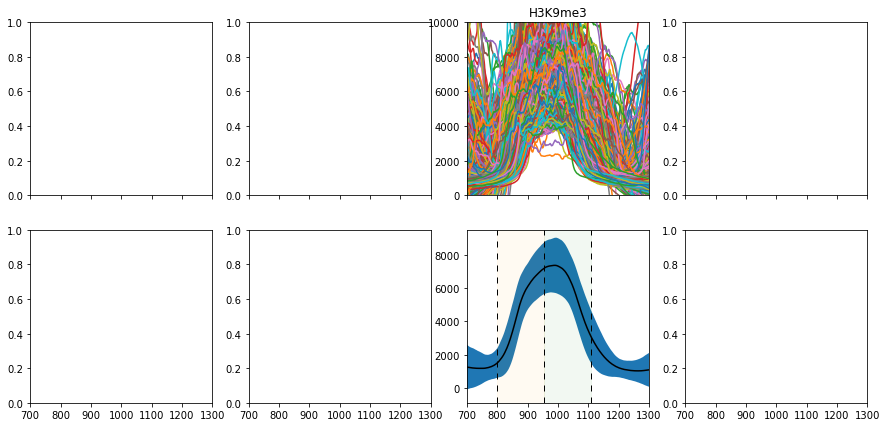

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

df_linescan_TB_C3 = df_linescan_TB_filterd.filter(regex='C3')

figure, ax = plt.subplots(ncols=4, nrows=2, figsize=(15,7), sharex=True) #, sharey=True)


ax[0,2].set(title="H3K9me3")
ax[0,2].plot(df_linescan_TB_C3) 
ax[1,2].plot(df_linescan_TB_C3.mean(axis=1),'k-')
ax[0,2].set_ylim(0,10000)
TB_C3_error_high = df_linescan_TB_C3.mean(axis=1) + df_linescan_TB_C3.std(axis=1)
TB_C3_error_low = df_linescan_TB_C3.mean(axis=1) - df_linescan_TB_C3.std(axis=1)
N=list(df_linescan_TB_C3.index)
ax[1,2].fill_between(N,TB_C3_error_high,TB_C3_error_low)
ax[1,2].set_xlim(700,1300)

midpoint = 954
span = (400/26)*10

ax[1,2].axvline(x=midpoint, dashes=[6,6], linewidth=1,color='k')
ax[1,2].axvline(x=midpoint-span, dashes=[6,6], linewidth=1,color='k')
ax[1,2].axvline(x=midpoint+span, dashes=[6,6], linewidth=1,color='k')
ax[1,2].axvspan((midpoint-span), midpoint, alpha=0.05, color='orange')
ax[1,2].axvspan(midpoint,(midpoint+span), alpha=0.05, color='green')

plt.show()

In [129]:
biorep_li = ["repG"]

for biorep_val in biorep_li:
    print(f'{biorep_val} contrains {df_linescan_TB_filterd.filter(like=biorep_val, axis=1).shape[1]/3:.0f} nuclei') 
    df_linescan_TB_filterd.filter(like=biorep_val, axis=1).to_csv(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\{exp_var}_RawLinescans_FILTERED_TB_{biorep_val}only.csv', index=False)   

repG contrains 0 nuclei


In [42]:
#so now that this is looking good, let's make a CNN that searches for these... 
line_IDs_abovemean =  df_TB_polarized.columns.values

In [ ]:
import shutil

cnn_export = r"G:\117/117_20190627_H3K9me3_quant_repGrepH/_pipeline/v1_repG_96hpiONLY/_training2/117_20190601_H3K9me3quant_repG_v1_CNNexport"

manually_sorted = os.path.join(os.getcwd(),"_training2","_manuallysorted","TB_perfect")
#os.makedirs(manually_sorted)

for x in line_IDs_abovemean:
    fn = x[:-3] + "_RGB.jpg"
    print(fn)
    new_filename = os.path.join(manually_sorted, fn)
    old_filename = os.path.join(cnn_export, fn)
    shutil.copy(old_filename, new_filename)

In [ ]:
def merge_MOCK_TB(df_MOCK, df_TB):
    df_FINAL = pd.concat([df_MOCK, df_TB], axis=1)
    print(df_MOCK.shape)
    print(df_TB.shape)
    print(df_FINAL.shape)
    return df_FINAL

In [ ]:
df_FINAL = merge_MOCK_TB(concat_df_MOCK,concat_df_TB)

In [ ]:
def getMEAN_SEM_UPPER_LOWER(df):
    df_T = df.T
    df_T["biorep"] = df_T.index.str.split('_').str[2]
    df_T["timepoint"] = df_T.index.str.split('_').str[3]
    df_T["channel"] = df_T.index.str.split('_').str[6]
    df_T.set_index(["biorep", "timepoint","channel"], inplace=True)
    df_tec_mean = df_T.groupby(["biorep","channel", "timepoint"]).mean()
    df_bio_mean = df_tec_mean.groupby(["channel", "timepoint"]).mean()
    df_bio_sem = df_tec_mean.groupby(["channel", "timepoint"]).std()/np.sqrt(3)
    df_upper = df_bio_mean + df_bio_sem
    df_lower = df_bio_mean - df_bio_sem
    return df_bio_mean, df_upper, df_lower

In [ ]:
df_bio_mean, df_upper, df_lower = getMEAN_SEM_UPPER_LOWER(df_FINAL)
df_bio_mean.head()

In [ ]:
def multi_chan(df_bio_mean,df_upper,df_lower):

    for channel_ID, channel_name in channel_dict.items():
        f = plt.figure()   
        ax = f.add_subplot(111)
        ax.plot(df_bio_mean.loc[(channel_ID,"96hpi")],'k-',label='_nolegend_')
        N=list(df_bio_mean.loc[(channel_ID,"96hpi")].index)
        ax.fill_between(N,df_upper.loc[(channel_ID,"96hpi")],df_lower.loc[(channel_ID,"96hpi")],label=f"TB-{channel_name}", alpha=0.5)
        ax.plot(df_bio_mean.loc[(channel_ID,"MOCK")],'k-',label='_nolegend_')
        N=list(df_bio_mean.loc[(channel_ID,"MOCK")].index)
        ax.fill_between(N,df_upper.loc[(channel_ID,"MOCK")],df_lower.loc[(channel_ID,"MOCK")],label=f"MOCK-{channel_name}", alpha=0.5)
        plt.legend()
        plt.show()

In [ ]:
#multi_chan(df_bio_mean,df_upper,df_lower)

In [ ]:
from matplotlib.ticker import FuncFormatter

def multi_chan_shifted(df_bio_mean,df_upper,df_lower,shift_val):
    MOCK_x_values = np.linspace(shift_val, (shift_val+2001), 2001)
    print(MOCK_x_values)
    for channel_ID, channel_name in channel_dict.items():
        f = plt.figure()   
        ax = f.add_subplot(111)
        
        increment = 1
        ticks_at = 5
        start_val = 12
        shift_axis = 62
        end_Val = start_val + shift_axis + 20
        
        
        ax.set_xlim( ((400/26)*increment)*start_val,((400/26)*increment)*(end_Val-1))
        ax.xaxis.set_ticks(np.arange(((400/26)*increment)*start_val, ((400/26)*increment)*end_Val, (400/26)*ticks_at))
        plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,y: '{}'.format(round((x*65)/1000,1)-shift_axis) ))
        ax.set_xlim(750,1250)
       
        #plot TB
        ax.plot(df_bio_mean.loc[(channel_ID,"96")],'k-',label='_nolegend_')
        N=list(df_bio_mean.loc[(channel_ID,"96")].index)
        ax.fill_between(N,df_upper.loc[(channel_ID,"96")],df_lower.loc[(channel_ID,"96")],label=f"{channel_name}-TB", alpha=0.5)
        
        #plot MOCK
        ax.plot(MOCK_x_values,df_bio_mean.loc[(channel_ID,"MOCK")],'k-',label='_nolegend_')
        N=list(df_bio_mean.loc[(channel_ID,"MOCK")].index)
        ax.fill_between(MOCK_x_values,df_upper.loc[(channel_ID,"MOCK")],df_lower.loc[(channel_ID,"MOCK")],label=f"{channel_name}-MOCK", alpha=0.5)
        
        ax.yaxis.tick_right()
        plt.legend()
        plt.savefig(f'{exp_var}_GRAP_{channel_name}.png', dpi=600)
        plt.show()
        

In [ ]:
channel_dict = {
    "C1":"gB",
    "C2":"Hoechst",
    "C3":"H3K9me3"}

multi_chan_shifted(df_bio_mean,df_upper,df_lower,465)

In [ ]:
def single_chan_MOCKvTB(df_mean,df_upper,df_lower):
    f = plt.figure()   
    ax = f.add_subplot(111)
    for channel_ID, channel_name in channel_dict.items():
        ax.plot(df_mean.loc[channel_ID],'k-',label='_nolegend_')
        N=list(df_mean.loc[channel_ID].index)
        ax.fill_between(N,df_upper.loc[channel_ID],df_lower.loc[channel_ID],label=f"TB-{channel_name}", alpha=0.5)
        plt.legend()
    plt.show()

In [ ]:
single_chan_MOCKvTB(df_mean,df_upper,df_lower)

In [ ]:
channel_dict = {
    "C1":"gB",
    "C2":"Hoechst",
    "C3":"H3K9me3"}

def single_chan(channel):
    channel_name = channel_dict.get(channel)
    f = plt.figure()   
    ax = f.add_subplot(111)
    ax.plot(df_mean.loc[channel],'k-')
    N=list(df_mean.loc[channel].index)
    ax.fill_between(N,df_upper.loc[channel],df_lower.loc[channel],label=f"TB-{channel_name}", alpha=0.5)
    plt.legend()
    plt.show()

## NOW WE CAN IMPORT FOR A VERSION PERFORMED ON ALL CHANNELS

In [ ]:
#these are the results for the high gB sample

#df_linescan_96_highGB = pd.read_csv("profile_TB_all.csv", na_values=0)
df_linescan_96_highGB = df_linescan_TB

In [ ]:
df_linescan_96_highGB.columns

In [ ]:
df_linescan_96_highGB_C1 = df_linescan_96_highGB.filter(regex='C1')
df_linescan_96_highGB_C1_repB = df_linescan_96_highGB_C1.filter(regex='repB')
df_linescan_96_highGB_C1_repC = df_linescan_96_highGB_C1.filter(regex='repC')
df_linescan_96_highGB_C1_repA = df_linescan_96_highGB_C1.filter(regex='repD')

In [ ]:
df_linescan_96_highGB_C2 = df_linescan_96_highGB.filter(regex='C2')
df_linescan_96_highGB_C2_repB = df_linescan_96_highGB_C2.filter(regex='repB')
df_linescan_96_highGB_C2_repC = df_linescan_96_highGB_C2.filter(regex='repC')
df_linescan_96_highGB_C2_repA = df_linescan_96_highGB_C2.filter(regex='repD')

In [ ]:
df_linescan_96_highGB_C3 = df_linescan_96_highGB.filter(regex='C3')
df_linescan_96_highGB_C3_repB = df_linescan_96_highGB_C3.filter(regex='repB')
df_linescan_96_highGB_C3_repC = df_linescan_96_highGB_C3.filter(regex='repC')
df_linescan_96_highGB_C3_repA = df_linescan_96_highGB_C3.filter(regex='repD')

In [ ]:
df_linescan_96_highGB_C4 = df_linescan_96_highGB.filter(regex='C4')
df_linescan_96_highGB_C4_repB = df_linescan_96_highGB_C4.filter(regex='repB')
df_linescan_96_highGB_C4_repC = df_linescan_96_highGB_C4.filter(regex='repC')
df_linescan_96_highGB_C4_repA = df_linescan_96_highGB_C4.filter(regex='repD')

In [ ]:
df_linescan_96_mean_C1 = pd.DataFrame({"repB":df_linescan_96_highGB_C1_repB.mean(axis=1), "repC":df_linescan_96_highGB_C1_repC.mean(axis=1), "repD":df_linescan_96_highGB_C1_repA.mean(axis=1)})

In [ ]:
df_linescan_96_mean_C2 = pd.DataFrame({"repB":df_linescan_96_highGB_C2_repB.mean(axis=1), "repC":df_linescan_96_highGB_C2_repC.mean(axis=1), "repD":df_linescan_96_highGB_C2_repA.mean(axis=1)})

In [ ]:
df_linescan_96_mean_C3 = pd.DataFrame({"repB":df_linescan_96_highGB_C3_repB.mean(axis=1), "repC":df_linescan_96_highGB_C3_repC.mean(axis=1), "repD":df_linescan_96_highGB_C3_repA.mean(axis=1)})

In [ ]:
df_linescan_96_mean_C4 = pd.DataFrame({"repB":df_linescan_96_highGB_C4_repB.mean(axis=1), "repC":df_linescan_96_highGB_C4_repC.mean(axis=1), "repD":df_linescan_96_highGB_C4_repA.mean(axis=1)})

In [ ]:
df_linescan_96_mean_C1_mean = df_linescan_96_mean_C1.mean(axis=1)
df_linescan_96_mean_C1_sem = df_linescan_96_mean_C1.std(axis=1)/np.sqrt(3)

In [ ]:
df_linescan_96_mean_C2_mean = df_linescan_96_mean_C2.mean(axis=1)
df_linescan_96_mean_C2_sem = df_linescan_96_mean_C2.std(axis=1)/np.sqrt(3)

In [ ]:
df_linescan_96_mean_C3_mean = df_linescan_96_mean_C3.mean(axis=1)
df_linescan_96_mean_C3_sem = df_linescan_96_mean_C3.std(axis=1)/np.sqrt(3)

In [ ]:
df_linescan_96_mean_C4_mean = df_linescan_96_mean_C4.mean(axis=1)
df_linescan_96_mean_C4_sem = df_linescan_96_mean_C4.std(axis=1)/np.sqrt(3)

In [ ]:
df_list_C1 = [df_linescan_96_highGB_C1_repA, df_linescan_96_highGB_C1_repB, df_linescan_96_highGB_C1_repC]

figure, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,15), sharex=True, sharey=True)

dftest = pd.DataFrame

for i, df in enumerate(df_list_C1):
    ax[i,0].plot(df_list_C1[i]) 
    graphLINE = df_list_C1[i].mean(axis=1)
    graphERROR = df_list_C1[i].std(axis=1)
    errorLOW=graphLINE-graphERROR
    errorHIGH=graphLINE+graphERROR
    N=list(graphLINE.index)
    ax[i,1].plot(graphLINE,'k-')
    ax[i,1].fill_between(N,errorHIGH,errorLOW)
    ax[0,2].plot(graphLINE)


errorLOW_C1=df_linescan_96_mean_C1_mean-df_linescan_96_mean_C1_sem
errorHIGH_C1=df_linescan_96_mean_C1_mean+df_linescan_96_mean_C1_sem
N=list(df_linescan_96_mean_C1_mean.index)
ax[1,2].plot(df_linescan_96_mean_C1_mean,'k-')
ax[1,2].fill_between(N,errorHIGH_C1,errorLOW_C1)

#plt.xlim(0,1000)
#plt.ylim(0,6000)

plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout
plt.show()


In [ ]:
df_list_C2 = [df_linescan_96_highGB_C2_repA, df_linescan_96_highGB_C2_repB, df_linescan_96_highGB_C2_repC]

figure, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,15), sharex=True, sharey=True)

dftest = pd.DataFrame

for i, df in enumerate(df_list_C2):
    ax[i,0].plot(df_list_C2[i]) 
    graphLINE = df_list_C2[i].mean(axis=1)
    graphERROR = df_list_C2[i].std(axis=1)
    errorLOW=graphLINE-graphERROR
    errorHIGH=graphLINE+graphERROR
    N=list(graphLINE.index)
    ax[i,1].plot(graphLINE,'k-')
    ax[i,1].fill_between(N,errorHIGH,errorLOW)
    ax[0,2].plot(graphLINE)


errorLOW_C2=df_linescan_96_mean_C2_mean-df_linescan_96_mean_C2_sem
errorHIGH_C2=df_linescan_96_mean_C2_mean+df_linescan_96_mean_C2_sem
N=list(df_linescan_96_mean_C2_mean.index)
ax[1,2].plot(df_linescan_96_mean_C2_mean,'k-')
ax[1,2].fill_between(N,errorHIGH_C2,errorLOW_C2)

#plt.xlim(0,1000)
#plt.ylim(0,6000)

plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout
plt.show()


In [ ]:
df_list_C3 = [df_linescan_96_highGB_C3_repA, df_linescan_96_highGB_C3_repB, df_linescan_96_highGB_C3_repC]

figure, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,15), sharex=True, sharey=True)

dftest = pd.DataFrame

for i, df in enumerate(df_list_C3):
    ax[i,0].plot(df_list_C3[i]) 
    graphLINE = df_list_C3[i].mean(axis=1)
    graphERROR = df_list_C3[i].std(axis=1)
    errorLOW=graphLINE-graphERROR
    errorHIGH=graphLINE+graphERROR
    N=list(graphLINE.index)
    ax[i,1].plot(graphLINE,'k-')
    ax[i,1].fill_between(N,errorHIGH,errorLOW)
    ax[0,2].plot(graphLINE)


errorLOW_C3=df_linescan_96_mean_C3_mean-df_linescan_96_mean_C3_sem
errorHIGH_C3=df_linescan_96_mean_C3_mean+df_linescan_96_mean_C3_sem
N=list(df_linescan_96_mean_C3_mean.index)
N_TB=list(df_linescan_96_mean_C3_mean.index)
ax[1,2].plot(df_linescan_96_mean_C3_mean,'k-')
ax[1,2].fill_between(N,errorHIGH_C3,errorLOW_C3)

plt.xlim(600,1400)
plt.ylim(0,6000)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout
plt.show()


In [ ]:
df_list_C4 = [df_linescan_96_highGB_C4_repA, df_linescan_96_highGB_C4_repB, df_linescan_96_highGB_C4_repC]

figure, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,15), sharex=True, sharey=True)

dftest = pd.DataFrame

for i, df in enumerate(df_list_C4):
    ax[i,0].plot(df_list_C4[i]) 
    graphLINE = df_list_C4[i].mean(axis=1)
    graphERROR = df_list_C4[i].std(axis=1)
    errorLOW=graphLINE-graphERROR
    errorHIGH=graphLINE+graphERROR
    N=list(graphLINE.index)
    ax[i,1].plot(graphLINE,'k-')
    ax[i,1].fill_between(N,errorHIGH,errorLOW)
    ax[0,2].plot(graphLINE)


errorLOW_C4=df_linescan_96_mean_C4_mean-df_linescan_96_mean_C4_sem
errorHIGH_C4=df_linescan_96_mean_C4_mean+df_linescan_96_mean_C4_sem
N=list(df_linescan_96_mean_C4_mean.index)
N_TB=list(df_linescan_96_mean_C4_mean.index)
ax[1,2].plot(df_linescan_96_mean_C4_mean,'k-')
ax[1,2].fill_between(N,errorHIGH_C4,errorLOW_C4)

#plt.xlim(0,1000)
plt.ylim(0,6000)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout
plt.show()


In [ ]:
len(N_TB)

In [ ]:
#DO THIS TO SHIFT
shift_val = 475
MOCK_x_values = np.linspace(shift_val, (shift_val+1000), 1001)
print(MOCK_x_values)

In [ ]:
df_linescan_TB.index.name = 'pixels'

#create a NaN dataframe so we can extend the MOCK dataframes
NaN_df = pd.DataFrame(0, index=df_linescan_96_mean_C3_mean.index, columns=['A'])
df_linescan_MOCK_mean_C3_mean =pd.DataFrame(df_linescan_MOCK_mean_C3_mean)
df_linescan_MOCK_mean_C3_mean.columns = ['A']
df_linescan_MOCK_mean_C3_mean_NaN = df_linescan_MOCK_mean_C3_mean.append(NaN_df)
df_linescan_MOCK_mean_C3_mean_NaN

In [ ]:
df_linescan_TB_transposed = df_linescan_TB.T

In [ ]:
df_linescan_TB_transposed["biorep"] = df_linescan_TB_transposed.index.str.split('_').str[2]
df_linescan_TB_transposed["timepoint"] = df_linescan_TB_transposed.index.str.split('_').str[3]
df_linescan_TB_transposed["channel"] = df_linescan_TB_transposed.index.str.split('_').str[6]

In [ ]:
#df_linescan_TB_transposed.reset_index(inplace=True)
df_linescan_TB_transposed.set_index(["biorep", "timepoint","channel"], inplace=True)

In [ ]:
df_linescan_TB_transposed.loc[('repB', '96hpi', 'C1')][:1]

In [ ]:
channel_dict = {
    "C1":"gB",
    "C2":"Hoechst",
    "C3":"SUN1",
    "C4":"AcMT"}

rep_dict = {
    1:"repB",
    2:"repC",
    3:"repD"}


for key, values in channel_dict.items():
    plt.plot(df_mean.loc[('repB', '96hpi', key)])
plt.show()

channel = "C1"
plt.plot(df_linescan_TB_transposed.loc[('repB', '96hpi', 'C1')][:1])
plt.show()

for key2, values in channel_dict.items():
    for key1, repID in rep_dict.items():
        plt.plot(df_mean.loc[(repID, '96hpi', key2)])
    plt.show()
    



In [ ]:
df_mean = df_linescan_TB_transposed.groupby(["channel"])
df_SEM = df_linescan_TB_transposed.groupby(["channel"]).std()/np.sqrt(3)

for row, value in df_mean.iterrows():
    print(value)
#df_linescan_TB_transposed.reset_index().groupby(["biorep","channel"]).std()/np.sqrt(3) #sometimes you'll need to user reset_index do this!

In [ ]:
df_linescan_TB_transposed.groupby(["channel"]).mean()

In [ ]:
>>> import seaborn as sns; sns.set()
>>> import matplotlib.pyplot as plt
>>> fmri = sns.load_dataset("fmri")
>>> ax = sns.lineplot(x="timepoint", y="signal", data=fmri)

In [ ]:
>>> ax = sns.lineplot(x="timepoint", y="signal", hue="event", ci=68, data=fmri)

In [ ]:
sns.lineplot(x="pixels", y="channel", data=df_linescan_TB_transposed)

In [ ]:
df_mean.reset_index().groupby(["channel"]).mean()

In [ ]:
for row,value in df_mean.reset_index().groupby(["biorep","channel"]).mean().iterrows():
    plt.plot(value)
plt.show

In [ ]:
channel_dict = {
    1:"gB",
    2:"Hoechst",
    3:"SUN1",
    4:"AcMT"}

rep_dict = {
    1:"repB",
    2:"repC",
    3:"repD"}

df_linescan_TB.groupby(["Metadata_timepoint_NUC"])

x_min = 200
x_max = 1200

for key, channel in channel_dict.items():
    print(channel)
    print(key)
"""
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    ax.plot(MOCK_x_values,df_linescan_MOCK_500_mean_C3_mean,'k-')
    ax.fill_between(MOCK_x_values,errorHIGH_MOCK_C3,errorLOW_MOCK_C3,label="MOCK", alpha=0.5)
    ax.plot(df_linescan_96_mean_C3_mean,'k-')
    ax.fill_between(N_TB,errorHIGH_C3,errorLOW_C3,label="TB96", alpha=0.5)
    ax.set_xlim( ((400/26)*2.5)*6,((400/26)*2.5)*22)
    ax.xaxis.set_ticks(np.arange(((400/26)*2.5)*6, ((400/26)*2.5)*23, (400/26)*5))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,y: '{}'.format(round((x*65)/1000,1)-30) ))
    plt.ylim(0,5999)
    plt.legend(loc=2,frameon=False)
    plt.savefig(f'{exp_var}_GRAPH_{C3_var}.png', dpi=600)
    plt.show()
"""

In [ ]:
from matplotlib.ticker import FuncFormatter



#### GRAPH 1 ####
#C3 for mock and infected
#plt.title(C3_var)





f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax.plot(MOCK_x_values,df_linescan_MOCK_500_mean_C3_mean,'k-')
ax.fill_between(MOCK_x_values,errorHIGH_MOCK_C3,errorLOW_MOCK_C3,label="MOCK", alpha=0.5)
ax.plot(df_linescan_96_mean_C3_mean,'k-')
ax.fill_between(N_TB,errorHIGH_C3,errorLOW_C3,label="TB96", alpha=0.5)
ax.set_xlim( ((400/26)*2.5)*6,((400/26)*2.5)*22)
ax.xaxis.set_ticks(np.arange(((400/26)*2.5)*6, ((400/26)*2.5)*23, (400/26)*5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,y: '{}'.format(round((x*65)/1000,1)-30) ))
plt.ylim(0,5999)
plt.legend(loc=2,frameon=False)
plt.savefig(f'{exp_var}_GRAPH_{C3_var}.png', dpi=600)
plt.show()

#### GRAPH 2 ####
#C2 for mock and infected
#plt.title(C2_var)
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax.plot(MOCK_x_values,df_linescan_MOCK_500_mean_C2_mean,'k-')
ax.fill_between(MOCK_x_values,errorHIGH_MOCK_C2,errorLOW_MOCK_C2,label="MOCK", alpha=0.5)
ax.plot(df_linescan_96_mean_C2_mean,'k-')
ax.fill_between(N_TB,errorHIGH_C2,errorLOW_C2,label="TB96", alpha=0.5)
ax.set_xlim( ((400/26)*2.5)*6,((400/26)*2.5)*22)
ax.xaxis.set_ticks(np.arange(((400/26)*2.5)*6, ((400/26)*2.5)*23, (400/26)*5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,y: '{}'.format(round((x*65)/1000,1)-30) ))
plt.legend(loc=2,frameon=False)
plt.savefig(f'{exp_var}_GRAPH_{C2_var}.png', dpi=600)
plt.show()

#### GRAPH 3 ####
#C1 for mock and infected
#plt.title(C1_var)
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax.plot(MOCK_x_values,df_linescan_MOCK_500_mean_C1_mean,'k-')
ax.fill_between(MOCK_x_values,errorHIGH_MOCK_C1,errorLOW_MOCK_C1,label="MOCK", alpha=0.5)
ax.plot(df_linescan_96_mean_C1_mean,'k-')
ax.fill_between(N_TB,errorHIGH_C1,errorLOW_C1,label="TB96", alpha=0.5)
ax.set_xlim( ((400/26)*2.5)*6,((400/26)*2.5)*22)
ax.xaxis.set_ticks(np.arange(((400/26)*2.5)*6, ((400/26)*2.5)*23, (400/26)*5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,y: '{}'.format(round((x*65)/1000,1)-30) ))
plt.legend(loc=2,frameon=False)
plt.savefig(f'{exp_var}_GRAPH_{C1_var}.png', dpi=600)
plt.show()

#### GRAPH 3 ####
#C4 for mock and infected
#plt.title(C1_var)
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax.plot(MOCK_x_values,df_linescan_MOCK_500_mean_C4_mean,'k-')
ax.fill_between(MOCK_x_values,errorHIGH_MOCK_C4,errorLOW_MOCK_C4,label="MOCK", alpha=0.5)
ax.plot(df_linescan_96_mean_C4_mean,'k-')
ax.fill_between(N_TB,errorHIGH_C4,errorLOW_C4,label="TB96", alpha=0.5)
ax.set_xlim( ((400/26)*2.5)*6,((400/26)*2.5)*22)
ax.xaxis.set_ticks(np.arange(((400/26)*2.5)*6, ((400/26)*2.5)*23, (400/26)*5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,y: '{}'.format(round((x*65)/1000,1)-30) ))
plt.legend(loc=2,frameon=False)
plt.savefig(f'{exp_var}_GRAPH_{C4_var}.png', dpi=600)
plt.show()

#### GRAPH 5 ####
#C1 for mock and infected
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax.plot(MOCK_x_values,df_linescan_MOCK_500_mean_C2_mean,'k-')
ax.fill_between(MOCK_x_values,errorHIGH_MOCK_C2,errorLOW_MOCK_C2,label="Hoechst-MOCK", alpha=0.5, color="#1f77b4")
ax.plot(df_linescan_96_mean_C2_mean,'k-')
ax.fill_between(N_TB,errorHIGH_C2,errorLOW_C2,label="Hoechst-TB96", alpha=0.5, color='#ff7f0e')

#ax.title(C1_var)
ax.plot(MOCK_x_values,df_linescan_MOCK_500_mean_C1_mean,'k-')
ax.fill_between(MOCK_x_values,errorHIGH_MOCK_C1,errorLOW_MOCK_C1,label="gB-MOCK", alpha=0.5, color="#aec7e8")
ax.plot(df_linescan_96_mean_C1_mean,'k-')
ax.fill_between(N_TB,errorHIGH_C1,errorLOW_C1,label="gB-TB96", alpha=0.5, color="#ffbb78")
plt.legend(loc=2,frameon=False)
ax.set_xlim( ((400/26)*2.5)*6,((400/26)*2.5)*22)
ax.xaxis.set_ticks(np.arange(((400/26)*2.5)*6, ((400/26)*2.5)*23, (400/26)*5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,y: '{}'.format(round((x*65)/1000,1)-30) ))
ax.yaxis.tick_right()
plt.savefig(f'{exp_var}_GRAPH_{C1_var}_{C1_var}.png', dpi=600)
plt.show()

"""
plt.plot(MOCK_x_values,df_linescan_MOCK_500_mean_C4_mean,'k-')
plt.fill_between(MOCK_x_values,errorHIGH_MOCK_C4,errorLOW_MOCK_C4,label="MOCK", alpha=0.5)

plt.plot(df_linescan_96_mean_C4_mean,'k-')
plt.fill_between(N_TB,errorHIGH_C4,errorLOW_C4,label="TB96", alpha=0.5)
plt.xlim(250,800)
plt.title("AcMT")
"""
#plt.legend()
#plt.savefig("AcMT.png", dpi=600)
plt.show()



In [ ]:
#this is how we count our n
MOCK_n_repB = df_linescan_MOCK_500_C1_repB.shape[1]
MOCK_n_repC = df_linescan_MOCK_500_C1_repC.shape[1]
MOCK_n_repA = df_linescan_MOCK_500_C1_repA.shape[1]
print([MOCK_n_repA, MOCK_n_repB, MOCK_n_repC])

TB_96_n_repB = df_linescan_96_highGB_C1_repB.shape[1]
TB_96_n_repC = df_linescan_96_highGB_C1_repC.shape[1]
TB_96_n_repA = df_linescan_96_highGB_C1_repA.shape[1]
print([TB_96_n_repA, TB_96_n_repB, TB_96_n_repC])